# Pytorch

### CNN (Convolutional Neural Network)

Convolutions are filters passed over the image of **some size** in **some stride**

E.g., `self.conv1 = nn.Conv2d(3, 6, 5)` means 
- We run our filter on a shape of (3,) for the channels, and producing an output of shape (6,).
- The 5 corresponds to the kernel size. This value can be an int or a float. When it is an int, like 5 here, that means the height and width of the kernel will be the same. In this example, the kernel is (5,5).

https://towardsdatascience.com/pytorch-conv2d-weights-explained-ff7f68f652eb

### Cross entropy loss (log loss)

Measures performance for classification models that output a probability between 0 and 1.

`-(y)(log(p))+(1-y)(log(1-p))`

This formula makes sense because if we have a value of 0 or 1, the log loss is 0. Log loss off 0 means loss is 0.

E.g., y=1, p=1, (1)(0) + (0)(0)

E.g., y=1, p=0, (1)(0) + (0)(0)

E.g., y=0, p=1, (0)(0) + (1)(0)



In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

In [8]:
# recap, transforms are way to manipulate data
# can transform the feature vector (e.g., using ToTensor())
# can transform the labels (e.g., one-hot encoding or multilabel encoding)
# compose() allows you to chain transforms
# in this case, we are converting to a tensor, and then normalizing  ...
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4



In [9]:
trainset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform)

testset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [10]:
trainloader = torch.utils.data.DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2)

testloader = torch.utils.data.DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2)

In [11]:
classes = {'plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [12]:
import matplotlib.pyplot as plt
import numpy as np

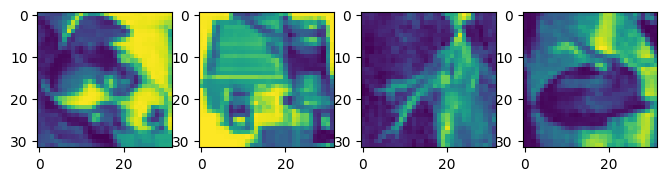

In [13]:
figure = plt.figure(figsize=(8, 8))
for i in range(1, batch_size + 1):
    figure.add_subplot(1, batch_size, i)
    img, label = next(iter(trainloader))
    # img is originally something like (4, 3, 32, 32)
    # transpose makes it (32, 32, 4, 3)
    # indexing with 0s allows us to removes the 3rd and 4th dimesnion 
    # this allows the images to be displayed as 2d objects of (32, 32)
    npimg = img.numpy().T
    plt.imshow(npimg[:, :, 0, 0])

In [14]:
import torch.nn as nn
import torch.nn.functional as F

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)  # final output has 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # the '1' in flatten keeps the first dimension,
        # which is the batch size 4
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
net = CNN()

In [17]:
import torch.optim as optim

In [18]:
logloss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [21]:
# remember, batch size is 4
# so in the inner for loop, we are making updates
#   4 data samples at a time
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # because data is actually a list of lists
        # it is [ [w/ 4 inputs], [w/ 4 labels] ]
        inputs, labels = data
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # run the inputs through network
        # again, inputs is [[i], [i+1],...,[batch_size-2], [batch_size-1]]
        outputs = net(inputs)
        loss = logloss(outputs, labels)
        loss.backward()
        optimizer.step()

        # prints
        running_loss += loss.item()
        if i%2000==1999: # every 2000 batches
            print(f"[{epoch+1}, {i+1:5d}] loss: {running_loss / 2000:.3f}")

            # reset loss sum!
            # this is key because it allows us to see the loss for 2000 batches
            # we should (and do) see the total loss reducing as the CNN is 
            #   trained on more samples
            running_loss = 0.0

print("Finish training.")



[1,  2000] loss: 2.303
[1,  4000] loss: 2.306
[1,  6000] loss: 2.308
[1,  8000] loss: 2.307
[1, 10000] loss: 2.305
[1, 12000] loss: 2.306
[2,  2000] loss: 2.306
[2,  4000] loss: 2.302
[2,  6000] loss: 2.310
[2,  8000] loss: 2.308
[2, 10000] loss: 2.309
[2, 12000] loss: 2.308
Finish training.


In [22]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [24]:
# again, 4 at a time
dataiter = iter(testloader)
images, labels = next(dataiter)

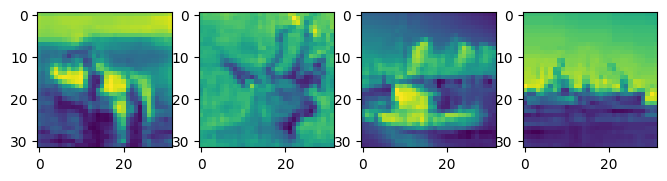

In [40]:
figure = plt.figure(figsize=(8,8))
for i in range(1, batch_size+1):
    figure.add_subplot(1, batch_size, i)
    image, label = next(iter(trainloader))
    plt.imshow(image[0, 0, :, :])